In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
%cd '/content/gdrive/My Drive/FireDetection/classification'

/content/gdrive/My Drive/FireDetection/classification


In [0]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from keras.models import Model, Sequential, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Conv2D, Dropout, Dense, Flatten, MaxPooling2D
from keras.applications import vgg16
import matplotlib.pyplot as plt
import time
from PIL import Image
import pandas as pd
import model_evaluation_utils as meu
from keras import optimizers

import model_plot_utils as plots


In [0]:
def showNumpyImage(image):
    plt.imshow(image, interpolation='nearest')
    plt.show()

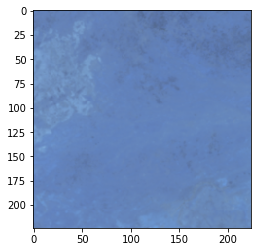

In [15]:
# Load Data
data = np.load("training_data.npy", allow_pickle = True)

# Split into labels and images then test and train
x = np.array([i[0] for i in data])
y = np.array([i[1] for i in data])
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size = 0.2, random_state = 42)

# Scale images
train_x_scaled = train_x.astype('float32')
test_x_scaled = test_x.astype('float32')
train_x_scaled /= 255
test_x_scaled /= 255

showNumpyImage(train_x_scaled[2600])

In [0]:
#!pip install efficientnet
import efficientnet.keras as efn 

In [67]:

input_shape = (224, 224, 3)

model_EfficientNetB0 = efn.EfficientNetB0(weights='imagenet', include_top = False, input_shape = input_shape)  # or weights='noisy-student'

#model_vgg16 = vgg16.VGG16(include_top = False, weights = 'imagenet', input_shape = input_shape)
output = model_EfficientNetB0.layers[-1].output
output = keras.layers.Flatten()(output)
EffNet0_model = Model(model_EfficientNetB0.input, output)

# Set blocks 4 and 5 to be fine tuneable
EffNet0_model.trainable = True

set_trainable = False
for layer in EffNet0_model.layers:
    if layer.name == 'block6b_add':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

layers = [(layer, layer.name, layer.trainable) for layer in EffNet0_model.layers]
layer_df = pd.DataFrame(layers, columns = ['Layer Type', 'Layer Name', 'Layer Trainable'])
layer_df.head()

,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at...,input_7,False
1,<keras.layers.convolutional.Conv2D object at 0...,stem_conv,False
2,<keras.layers.normalization.BatchNormalization...,stem_bn,False
3,<keras.layers.core.Activation object at 0x7f74...,stem_activation,False
4,<keras.layers.convolutional.DepthwiseConv2D ob...,block1a_dwconv,False


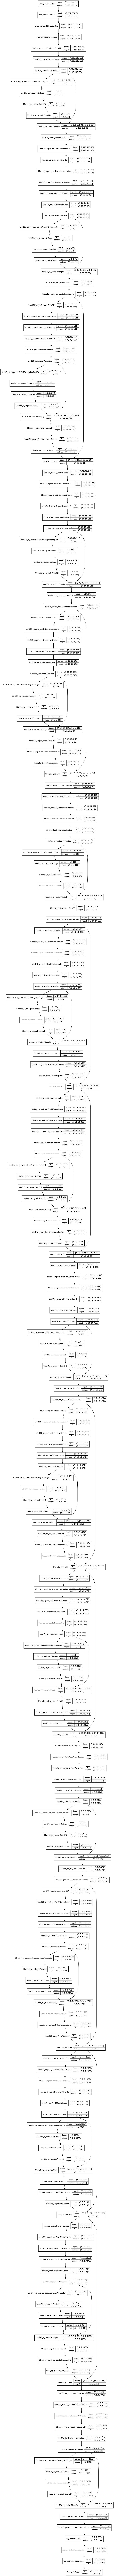

In [10]:
from tensorflow.keras.utils import plot_model
plot_model(EffNet0_model, to_file='conv_base.png', show_shapes=True)
from IPython.display import Image
Image(filename='conv_base.png') 

In [16]:
# Run model for unaugmented data
model = Sequential()
model.add(EffNet0_model)
model.add(Dense(512, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))


model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(),
              metrics=['accuracy'])


history = model.fit(train_x_scaled, train_y, batch_size=32, epochs=10, validation_split = 0.2,
                              verbose=1)       




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 2784 samples, validate on 696 samples
Epoch 1/10


KeyboardInterrupt: ignored

In [0]:
# Make predictions with model and convert predictions into binary
test_predictions = model.predict(test_x_scaled)
test_predictions_labelled = [0 if x<0.1 else 1 for x in test_predictions]

In [18]:
# Display performance metrics
meu.display_model_performance_metrics(true_labels=test_y, predicted_labels=test_predictions_labelled, classes=list(set(test_y)))

Model Performance metrics:
------------------------------
Accuracy: 0.9586
Precision: 0.9504
Recall: 0.9586
F1 Score: 0.9531

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       833
           1       0.52      0.30      0.38        37

    accuracy                           0.96       870
   macro avg       0.75      0.64      0.68       870
weighted avg       0.95      0.96      0.95       870


Prediction Confusion Matrix:
------------------------------
          Predicted:    
                   0   1
Actual: 0        823  10
        1         26  11


/content/gdrive/My Drive/FireDetection/classification/model_evaluation_utils.py:62: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  labels=level_labels),
/content/gdrive/My Drive/FireDetection/classification/model_evaluation_utils.py:64: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  labels=level_labels))


In [0]:
# Extract just fire images for augmentation
# TODO: this is not very efficient
data_df = pd.DataFrame(data)
just_fire = data_df[data_df[1] ==1]
just_fire_images = just_fire[0].tolist()
just_fire_labels = just_fire[1].tolist()

In [0]:
fire_data_aug = ImageDataGenerator(rescale=1./255, zoom_range=0.3, rotation_range=50,
                                   width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, 
                                   horizontal_flip=True, vertical_flip=True, fill_mode='nearest')

In [0]:
# Produce 12 random augmented image per fire image
from numpy import expand_dims
aug_images = []
aug_image_lables = []
for image in just_fire_images:
    image = expand_dims(image,0)
    it = fire_data_aug.flow(image, batch_size=1)
    for i in range(12):
        batch = it.next()
        aug_images.append(batch[0])
        aug_image_lables.append(1)

In [69]:
train_x_aug.shape, train_x_scaled.shape

((5820, 224, 224, 3), (3480, 224, 224, 3))

In [0]:
# Create new augmented training and label set by combining original training and augmented training sets
train_x_aug = np.concatenate((train_x_scaled,np.array(aug_images)))
train_y_aug = np.concatenate((train_y,np.array(aug_image_lables)))

In [70]:
# Run model with augmented data 
model_aug = Sequential()
model_aug.add(EffNet0_model)
model_aug.add(Dense(512, activation='relu', input_dim=input_shape))
model_aug.add(Dropout(0.3))
model_aug.add(Dense(512, activation='relu'))
model_aug.add(Dropout(0.3))
model_aug.add(Dense(1, activation='sigmoid'))

model_aug.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(),
              metrics=['accuracy'])

early_stopping_monitor = EarlyStopping(patience=10)
              
history_aug = model_aug.fit(train_x_aug, train_y_aug, batch_size=32, epochs=20, validation_split = 0.2,
                              verbose=1, shuffle = True, callbacks = [early_stopping_monitor])  

Train on 4656 samples, validate on 1164 samples
Epoch 1/20
4656/4656 [==============================] - 33s 7ms/step - loss: 0.7330 - acc: 0.9334 - val_loss: 15.1367 - val_acc: 0.0550
Epoch 2/20
4656/4656 [==============================] - 13s 3ms/step - loss: 0.9035 - acc: 0.9399 - val_loss: 10.2184 - val_acc: 0.3514
Epoch 3/20
4656/4656 [==============================] - 13s 3ms/step - loss: 0.8129 - acc: 0.9467 - val_loss: 13.2862 - val_acc: 0.1718
Epoch 4/20
4656/4656 [==============================] - 13s 3ms/step - loss: 1.0922 - acc: 0.9308 - val_loss: 7.8042 - val_acc: 0.5146
Epoch 5/20
4656/4656 [==============================] - 13s 3ms/step - loss: 1.7143 - acc: 0.8922 - val_loss: 13.1511 - val_acc: 0.1813
Epoch 6/20
4656/4656 [==============================] - 13s 3ms/step - loss: 1.7561 - acc: 0.8907 - val_loss: 12.8412 - val_acc: 0.2027
Epoch 7/20
4656/4656 [==============================] - 13s 3ms/step - loss: 1.1808 - acc: 0.9263 - val_loss: 8.8955 - val_acc: 0.4450
Ep

In [71]:
# Make preditions with augmented data model & convert to binary
test_predictions_aug = model_aug.predict(test_x_scaled)
test_predictions_aug_labelled = [0 if x<0.1 else 1 for x in test_predictions_aug]

# Display performance metrics (12X augmentation, incl. vertical_flip, 20 Epoch)
meu.display_model_performance_metrics(true_labels=test_y, predicted_labels=test_predictions_aug_labelled, classes=list(set(test_y)))

Model Performance metrics:
------------------------------
Accuracy: 0.9575
Precision: 0.9168
Recall: 0.9575
F1 Score: 0.9367

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       833
           1       0.00      0.00      0.00        37

    accuracy                           0.96       870
   macro avg       0.48      0.50      0.49       870
weighted avg       0.92      0.96      0.94       870


Prediction Confusion Matrix:
------------------------------
          Predicted:   
                   0  1
Actual: 0        833  0
        1         37  0


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/content/gdrive/My Drive/FireDetection/classification/model_evaluation_utils.py:62: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  labels=level_labels),
/content/gdrive/My Drive/FireDetection/classification/model_evaluation_utils.py:64: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  labels=level_labels))


In [25]:
# Display performance metrics (12X augmentation, incl. vertical_flip, 20 Epoch)
meu.display_model_performance_metrics(true_labels=test_y, predicted_labels=test_predictions_aug_labelled, classes=list(set(test_y)))

Model Performance metrics:
------------------------------
Accuracy: 0.9506
Precision: 0.9512
Recall: 0.9506
F1 Score: 0.9509

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       833
           1       0.42      0.43      0.43        37

    accuracy                           0.95       870
   macro avg       0.70      0.70      0.70       870
weighted avg       0.95      0.95      0.95       870


Prediction Confusion Matrix:
------------------------------
          Predicted:    
                   0   1
Actual: 0        811  22
        1         21  16


/content/gdrive/My Drive/FireDetection/classification/model_evaluation_utils.py:62: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  labels=level_labels),
/content/gdrive/My Drive/FireDetection/classification/model_evaluation_utils.py:64: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  labels=level_labels))


KeyError: ignored

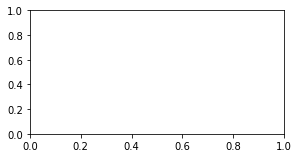

In [26]:
plots.plot_accuracy_loss(history_aug)

In [0]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training the network
    """
    fig = plt.figure(figsize=(15,10))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['acc'],'bo--', label = "acc")
    plt.plot(history.history['val_acc'], 'ro--', label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

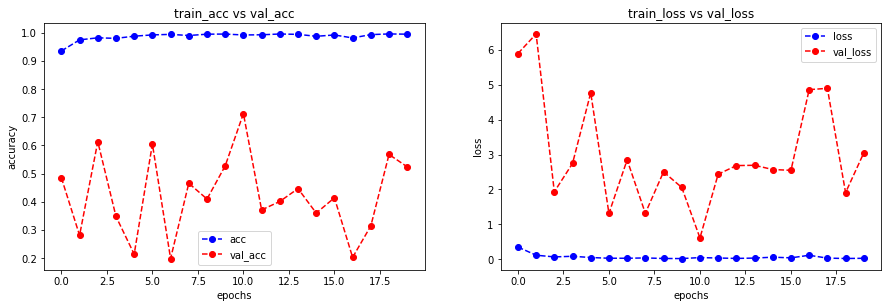

In [33]:
plot_accuracy_loss(history_aug)

In [41]:
input_shape = (224, 224, 3)

model_EfficientNetB0 = efn.EfficientNetB0(weights='imagenet', include_top = False, input_shape = input_shape)  # or weights='noisy-student'

#model_vgg16 = vgg16.VGG16(include_top = False, weights = 'imagenet', input_shape = input_shape)
output = model_EfficientNetB0.layers[-1].output
output = keras.layers.Flatten()(output)
EffNet0_model = Model(model_EfficientNetB0.input, output)

# Set blocks 4 and 5 to be fine tuneable
EffNet0_model.trainable = True

set_trainable = False
for layer in EffNet0_model.layers:
    if layer.name == '':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

layers = [(layer, layer.name, layer.trainable) for layer in EffNet0_model.layers]
layer_df = pd.DataFrame(layers, columns = ['Layer Type', 'Layer Name', 'Layer Trainable'])
layer_df.head()

,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at...,input_3,False
1,<keras.layers.convolutional.Conv2D object at 0...,stem_conv,False
2,<keras.layers.normalization.BatchNormalization...,stem_bn,False
3,<keras.layers.core.Activation object at 0x7f75...,stem_activation,False
4,<keras.layers.convolutional.DepthwiseConv2D ob...,block1a_dwconv,False


In [46]:
# Run model with augmented data 
model_aug = Sequential()
model_aug.add(EffNet0_model)
model_aug.add(Dense(512, activation='relu', input_dim=input_shape))
model_aug.add(Dropout(0.3))
model_aug.add(Dense(512, activation='relu'))
model_aug.add(Dropout(0.3))
model_aug.add(Dense(1, activation='sigmoid'))

model_aug.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(),
              metrics=['accuracy'])

early_stopping_monitor = EarlyStopping(patience=10)
              
history_aug = model_aug.fit(train_x_aug, train_y_aug, batch_size=32, epochs=30, validation_split = 0.2,
                              verbose=1, callbacks=[early_stopping_monitor])  

Train on 4656 samples, validate on 1164 samples
Epoch 1/30
4656/4656 [==============================] - 20s 4ms/step - loss: 1.2894 - acc: 0.8986 - val_loss: 13.4936 - val_acc: 0.1383
Epoch 2/30
4656/4656 [==============================] - 10s 2ms/step - loss: 1.2163 - acc: 0.9188 - val_loss: 10.3114 - val_acc: 0.3376
Epoch 3/30
4656/4656 [==============================] - 10s 2ms/step - loss: 1.5808 - acc: 0.8993 - val_loss: 14.0082 - val_acc: 0.1246
Epoch 4/30
4656/4656 [==============================] - 10s 2ms/step - loss: 1.2857 - acc: 0.9186 - val_loss: 13.1455 - val_acc: 0.1761
Epoch 5/30
4656/4656 [==============================] - 10s 2ms/step - loss: 1.6590 - acc: 0.8945 - val_loss: 10.2732 - val_acc: 0.3514
Epoch 6/30
4656/4656 [==============================] - 10s 2ms/step - loss: 1.2645 - acc: 0.9203 - val_loss: 13.1141 - val_acc: 0.1796
Epoch 7/30
4656/4656 [==============================] - 10s 2ms/step - loss: 1.1906 - acc: 0.9250 - val_loss: 12.4527 - val_acc: 0.2208


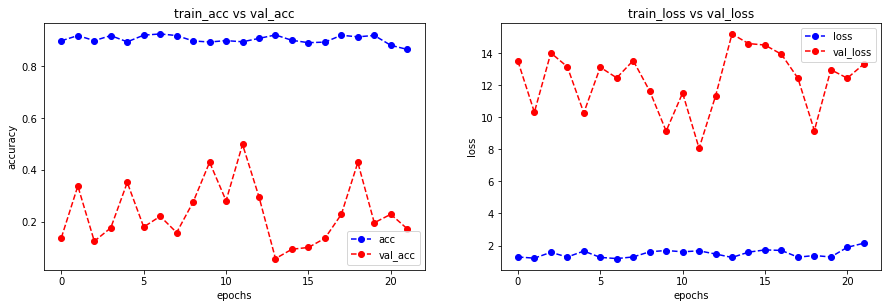

In [47]:
plot_accuracy_loss(history_aug)

In [0]:
# Make preditions with augmented data model & convert to binary
test_predictions_aug = model_aug.predict(test_x_scaled)
test_predictions_aug_labelled = [0 if x<0.1 else 1 for x in test_predictions_aug]

# Display performance metrics (12X augmentation, incl. vertical_flip, 20 Epoch)
meu.display_model_performance_metrics(true_labels=test_y, predicted_labels=test_predictions_aug_labelled, classes=list(set(test_y)))

In [45]:
# Display performance metrics (12X augmentation, incl. vertical_flip, 20 Epoch)
meu.display_model_performance_metrics(true_labels=test_y, predicted_labels=test_predictions_aug_labelled, classes=list(set(test_y)))

Model Performance metrics:
------------------------------
Accuracy: 0.9552
Precision: 0.9167
Recall: 0.9552
F1 Score: 0.9355

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       833
           1       0.00      0.00      0.00        37

    accuracy                           0.96       870
   macro avg       0.48      0.50      0.49       870
weighted avg       0.92      0.96      0.94       870


Prediction Confusion Matrix:
------------------------------
          Predicted:   
                   0  1
Actual: 0        831  2
        1         37  0


/content/gdrive/My Drive/FireDetection/classification/model_evaluation_utils.py:62: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  labels=level_labels),
/content/gdrive/My Drive/FireDetection/classification/model_evaluation_utils.py:64: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  labels=level_labels))


In [49]:
#block5c_add
input_shape = (224, 224, 3)

model_EfficientNetB0 = efn.EfficientNetB0(weights='imagenet', include_top = False, input_shape = input_shape)  # or weights='noisy-student'

#model_vgg16 = vgg16.VGG16(include_top = False, weights = 'imagenet', input_shape = input_shape)
output = model_EfficientNetB0.layers[-1].output
output = keras.layers.Flatten()(output)
EffNet0_model = Model(model_EfficientNetB0.input, output)

# Set blocks 4 and 5 to be fine tuneable
EffNet0_model.trainable = True

set_trainable = False
for layer in EffNet0_model.layers:
    if layer.name == 'block5c_add':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

layers = [(layer, layer.name, layer.trainable) for layer in EffNet0_model.layers]
layer_df = pd.DataFrame(layers, columns = ['Layer Type', 'Layer Name', 'Layer Trainable'])
layer_df.head()

,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at...,input_4,False
1,<keras.layers.convolutional.Conv2D object at 0...,stem_conv,False
2,<keras.layers.normalization.BatchNormalization...,stem_bn,False
3,<keras.layers.core.Activation object at 0x7f75...,stem_activation,False
4,<keras.layers.convolutional.DepthwiseConv2D ob...,block1a_dwconv,False


In [50]:
# Run model with augmented data 
model_aug = Sequential()
model_aug.add(EffNet0_model)
model_aug.add(Dense(512, activation='relu', input_dim=input_shape))
model_aug.add(Dropout(0.3))
model_aug.add(Dense(512, activation='relu'))
model_aug.add(Dropout(0.3))
model_aug.add(Dense(1, activation='sigmoid'))

model_aug.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(),
              metrics=['accuracy'])

early_stopping_monitor = EarlyStopping(patience=10)
              
history_aug = model_aug.fit(train_x_aug, train_y_aug, batch_size=32, epochs=30, validation_split = 0.2,
                              verbose=1, callbacks=[early_stopping_monitor]) 

Train on 4656 samples, validate on 1164 samples
Epoch 1/30
4656/4656 [==============================] - 27s 6ms/step - loss: 0.5624 - acc: 0.9360 - val_loss: 11.9748 - val_acc: 0.1770
Epoch 2/30
4656/4656 [==============================] - 13s 3ms/step - loss: 0.1850 - acc: 0.9676 - val_loss: 1.6933 - val_acc: 0.4003
Epoch 3/30
4656/4656 [==============================] - 13s 3ms/step - loss: 0.1150 - acc: 0.9766 - val_loss: 0.5997 - val_acc: 0.7259
Epoch 4/30
4656/4656 [==============================] - 13s 3ms/step - loss: 0.1149 - acc: 0.9712 - val_loss: 3.0059 - val_acc: 0.1134
Epoch 5/30
4656/4656 [==============================] - 13s 3ms/step - loss: 0.0668 - acc: 0.9815 - val_loss: 5.3625 - val_acc: 0.1469
Epoch 6/30
4656/4656 [==============================] - 13s 3ms/step - loss: 0.0632 - acc: 0.9848 - val_loss: 4.4971 - val_acc: 0.2440
Epoch 7/30
4656/4656 [==============================] - 13s 3ms/step - loss: 0.0754 - acc: 0.9802 - val_loss: 4.3672 - val_acc: 0.1349
Epoch 

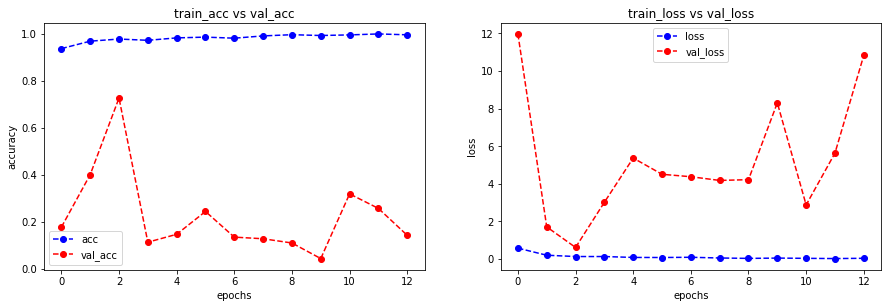

In [51]:
plot_accuracy_loss(history_aug)

In [52]:
# Make preditions with augmented data model & convert to binary
test_predictions_aug = model_aug.predict(test_x_scaled)
test_predictions_aug_labelled = [0 if x<0.1 else 1 for x in test_predictions_aug]

# Display performance metrics (12X augmentation, incl. vertical_flip, 20 Epoch)
meu.display_model_performance_metrics(true_labels=test_y, predicted_labels=test_predictions_aug_labelled, classes=list(set(test_y)))

Model Performance metrics:
------------------------------
Accuracy: 0.9621
Precision: 0.9635
Recall: 0.9621
F1 Score: 0.9472

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       833
           1       1.00      0.11      0.20        37

    accuracy                           0.96       870
   macro avg       0.98      0.55      0.59       870
weighted avg       0.96      0.96      0.95       870


Prediction Confusion Matrix:
------------------------------
          Predicted:   
                   0  1
Actual: 0        833  0
        1         33  4


/content/gdrive/My Drive/FireDetection/classification/model_evaluation_utils.py:62: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  labels=level_labels),
/content/gdrive/My Drive/FireDetection/classification/model_evaluation_utils.py:64: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  labels=level_labels))


# EfficientNetB3

In [54]:
input_shape = (224, 224, 3)

model_EfficientNetB3 = efn.EfficientNetB3(weights='imagenet', include_top = False, input_shape = input_shape)  # or weights='noisy-student'

output = model_EfficientNetB3.layers[-1].output
output = keras.layers.Flatten()(output)
EffNet3_model = Model(model_EfficientNetB3.input, output)


from tensorflow.keras.utils import plot_model
from IPython.display import Image

plot_model(EffNet0_model, to_file='conv_ENB3.png', show_shapes=True)
Image(filename='conv_ENB3.png') 

# Set some layers to be fine tuneable
EffNet3_model.trainable = True

set_trainable = False
for layer in EffNet3_model.layers:
    if layer.name == 'block5c_add':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

layers = [(layer, layer.name, layer.trainable) for layer in EffNet0_model.layers]
layer_df = pd.DataFrame(layers, columns = ['Layer Type', 'Layer Name', 'Layer Trainable'])
layer_df.head()

,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at...,input_4,False
1,<keras.layers.convolutional.Conv2D object at 0...,stem_conv,False
2,<keras.layers.normalization.BatchNormalization...,stem_bn,False
3,<keras.layers.core.Activation object at 0x7f75...,stem_activation,False
4,<keras.layers.convolutional.DepthwiseConv2D ob...,block1a_dwconv,False


In [64]:
# Run model with augmented data 
model_aug = Sequential()
model_aug.add(EffNet0_model)
model_aug.add(Dense(256, activation='relu', input_dim=input_shape))
model_aug.add(Dropout(0.5))
model_aug.add(Dense(128, activation='relu'))
model_aug.add(Dropout(0.3))
model_aug.add(Dense(1, activation='sigmoid'))

model_aug.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(0.0001),
              metrics=['accuracy'])

early_stopping_monitor = EarlyStopping(patience=3)
              
history_aug = model_aug.fit(train_x_aug, train_y_aug, batch_size=32, epochs=30, validation_split = 0.2,
                              verbose=1, callbacks=[early_stopping_monitor],  shuffle = True) 

Train on 4656 samples, validate on 1164 samples
Epoch 1/30
4656/4656 [==============================] - 34s 7ms/step - loss: 1.9791 - acc: 0.8709 - val_loss: 14.8720 - val_acc: 0.0773
Epoch 2/30
4656/4656 [==============================] - 14s 3ms/step - loss: 1.4386 - acc: 0.9107 - val_loss: 15.3288 - val_acc: 0.0490
Epoch 3/30
4656/4656 [==============================] - 14s 3ms/step - loss: 2.1048 - acc: 0.8679 - val_loss: 13.4917 - val_acc: 0.1624
Epoch 4/30
4656/4656 [==============================] - 14s 3ms/step - loss: 1.7837 - acc: 0.8887 - val_loss: 11.2577 - val_acc: 0.3015
Epoch 5/30
4656/4656 [==============================] - 14s 3ms/step - loss: 1.7049 - acc: 0.8937 - val_loss: 10.1090 - val_acc: 0.3720
Epoch 6/30
4656/4656 [==============================] - 14s 3ms/step - loss: 1.5078 - acc: 0.9059 - val_loss: 14.7195 - val_acc: 0.0868
Epoch 7/30
4656/4656 [==============================] - 14s 3ms/step - loss: 1.3953 - acc: 0.9132 - val_loss: 15.7858 - val_acc: 0.0206


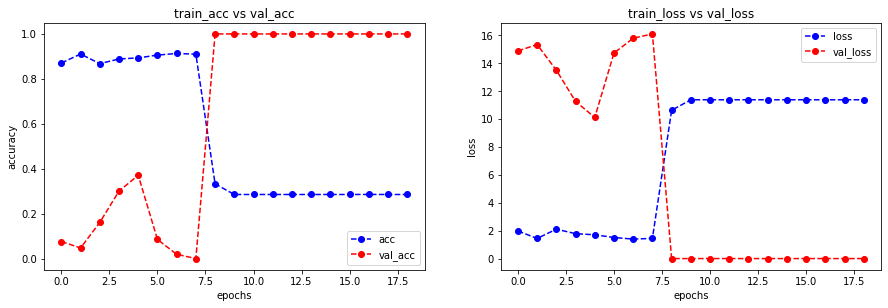

In [65]:
plot_accuracy_loss(history_aug)

In [66]:
# Make preditions with augmented data model & convert to binary
test_predictions_aug = model_aug.predict(test_x_scaled)
test_predictions_aug_labelled = [0 if x<0.1 else 1 for x in test_predictions_aug]

# Display performance metrics (12X augmentation, incl. vertical_flip, 20 Epoch)
meu.display_model_performance_metrics(true_labels=test_y, predicted_labels=test_predictions_aug_labelled, classes=list(set(test_y)))

Model Performance metrics:
------------------------------
Accuracy: 0.0425
Precision: 0.0018
Recall: 0.0425
F1 Score: 0.0035

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       833
           1       0.04      1.00      0.08        37

    accuracy                           0.04       870
   macro avg       0.02      0.50      0.04       870
weighted avg       0.00      0.04      0.00       870


Prediction Confusion Matrix:
------------------------------
          Predicted:     
                   0    1
Actual: 0          0  833
        1          0   37


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/content/gdrive/My Drive/FireDetection/classification/model_evaluation_utils.py:62: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  labels=level_labels),
/content/gdrive/My Drive/FireDetection/classification/model_evaluation_utils.py:64: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  labels=level_labels))
